# NN (L) Global Sustainable Equity time series forecasting using Prophet

## Start timing the analysis

In [1]:
import timeit
start_time = timeit.default_timer()

## Import all the necessary libraries

In [2]:
# Import all the necessary libraries
import time
import os
import datetime as dt
import pandas as pd
import io
import matplotlib.pyplot as plt

from fbprophet import Prophet
import itertools
import numpy as np
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics
import warnings
from dask.distributed import Client # import Dask for parallelising cross validation

## Import, clean and visualise the historical data

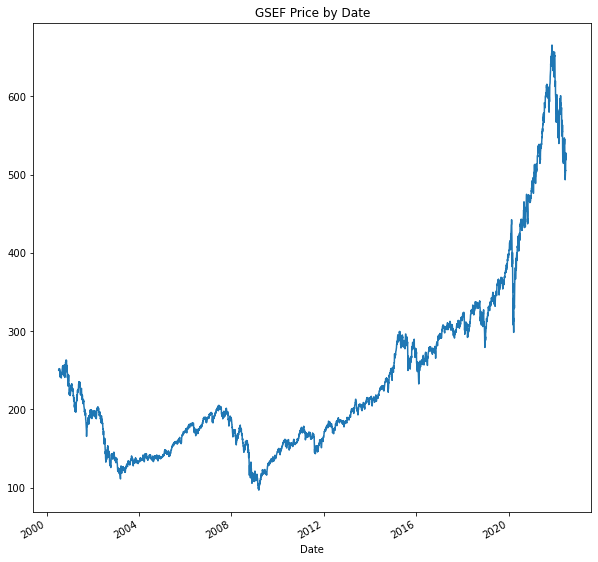

In [3]:
warnings.filterwarnings("ignore")

pd.set_option('display.max_column',None)
tomorrow = (dt.date.today() + dt.timedelta(days=1)).isoformat() #get tomorrow in iso format as needed'''
url = pd.read_html("https://markets.ft.com/data/funds/tearsheet/historical?s=LU0119216553:EUR", header=0)
table = url[0]
gsef_latest = table[['Date', 'Close']]
gsef_latest_selected= gsef_latest.copy()

gsef_latest_selected['Date'] = gsef_latest_selected.loc[:,'Date'].str[-12:]
gsef_latest_selected['Date'] = pd.to_datetime(gsef_latest_selected['Date'], dayfirst=True)

gsef_historical= pd.read_csv('gsef_output/historical_gsef.csv', parse_dates=['Date'], dayfirst=True)

gsef = pd.concat([gsef_latest_selected, gsef_historical], ignore_index=True).sort_values(by="Date")

gsef = gsef.reset_index(drop=True)

gsef['pct_change']= (gsef["Close"].pct_change()*100).round(2)

gsef = gsef.drop_duplicates('Date')

gsef.to_csv('gsef_output/historical_gsef.csv', index=False)

gsef.plot(x= 'Date', y='Close', figsize=(10,10), title= 'GSEF Price by Date', legend=False)

historical_chart= 'gsef_output/gsef_historical.png'

# Check if the historical data's chart exists and save its latest version
if os.path.exists(historical_chart):
  os.remove(historical_chart)
else:
  print("The historical chart didn't exist and it has been created.")

plt.savefig('gsef_output/gsef_historical.png')

plt.show()

In [4]:
# Brief Description of our dataset
gsef.describe()

Close   pct_change
count  5549.000000  5548.000000
mean    239.447729     0.019191
std     117.915841     1.084660
min      96.810000    -9.930000
25%     157.460000    -0.470000
50%     195.640000     0.070000
75%     292.290000     0.550000
max     665.450000     9.540000

In [5]:
gsef.info() # Check whether the date is as object type or date type

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5549 entries, 0 to 5567
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Date        5549 non-null   datetime64[ns]
 1   Close       5549 non-null   float64       
 2   pct_change  5548 non-null   float64       
dtypes: datetime64[ns](1), float64(2)
memory usage: 173.4 KB


In [6]:
gsef.tail()

Date   Close  pct_change
5559 2022-06-22  504.83       -0.15
5561 2022-06-23  514.48        1.91
5563 2022-06-24  527.69        2.57
5565 2022-06-27  526.49       -0.23
5567 2022-06-28  519.14       -1.40

In [7]:
# Drop the columns
gsef = gsef.drop('pct_change', axis=1)
gsef.rename(columns={'Close': 'y', 'Date': 'ds'}, inplace=True)

gsef.tail()

ds       y
5559 2022-06-22  504.83
5561 2022-06-23  514.48
5563 2022-06-24  527.69
5565 2022-06-27  526.49
5567 2022-06-28  519.14

## Hyperparameter tuning

In [8]:
client = Client()  # connect to the cluster

# param_grid = {  
#     'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
#     'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
#     'daily_seasonality': [False]
# }

# # Generate all combinations of parameters
# all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
# rmses = []  # Store the RMSEs for each params here

# # Use cross validation to evaluate all parameters
# for params in all_params:
#     m = Prophet(**params).fit(gsef)  # Fit model with given params
#     df_cv = cross_validation(m, horizon='30 days', parallel="dask")
#     df_p = performance_metrics(df_cv, rolling_window=1)
#     rmses.append(df_p['rmse'].values[0])

# # Find the best parameters
# tuning_results = pd.DataFrame(all_params)
# tuning_results['rmse'] = rmses
# print(tuning_results)

In [9]:
# best_params = all_params[np.argmin(rmses)]
# print(best_params)

In [10]:
# changepoint_prior_scale= best_params['changepoint_prior_scale'] # last selected changepoint_prior_scale= 0.5
# seasonality_prior_scale= best_params['seasonality_prior_scale'] # last selected seasonality_prior_scale= 0.01

## Initiating and training the Prophet algorithm

Steps for using Prophet:
- Make sure you replace closing price for y and date for ds.
- Fit that dataframe to Prophet in order to detect future patterns.
- Predict the upper and lower prices of the closing price.

In [11]:
#m = Prophet(daily_seasonality=False, changepoint_prior_scale= changepoint_prior_scale, seasonality_prior_scale= seasonality_prior_scale)

m = Prophet(daily_seasonality=False, weekly_seasonality=False)

m.fit(gsef)

In [12]:
# Create Future dates
future_prices = m.make_future_dataframe(periods=365)

# Predict Prices
forecast = m.predict(future_prices)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

ds        yhat  yhat_lower  yhat_upper
5909 2023-06-24  672.041218  640.959586  705.906212
5910 2023-06-25  672.407421  640.569592  705.102236
5911 2023-06-26  672.800474  641.332967  704.820070
5912 2023-06-27  673.217949  641.672222  705.332357
5913 2023-06-28  673.656946  642.758937  706.250106

You can plot the forecast by calling the Prophet.plot method and passing in your forecast dataframe.

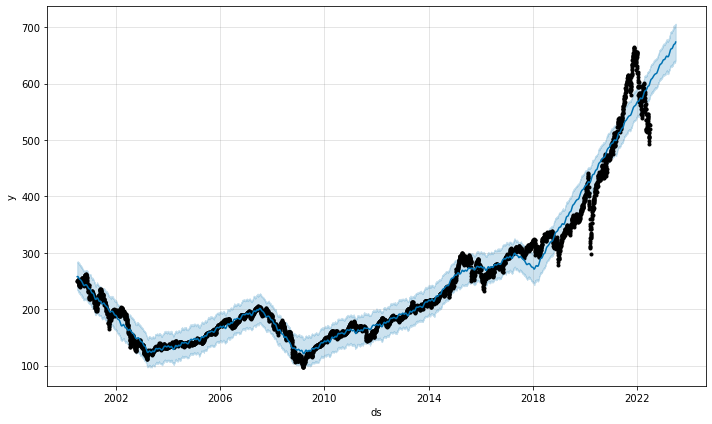

In [13]:
fig1 = m.plot(forecast)

If you want to see the forecast components, you can use the Prophet.plot_components method. By default you’ll see the trend, yearly seasonality, and weekly seasonality of the time series. If you include holidays, you’ll see those here, too.

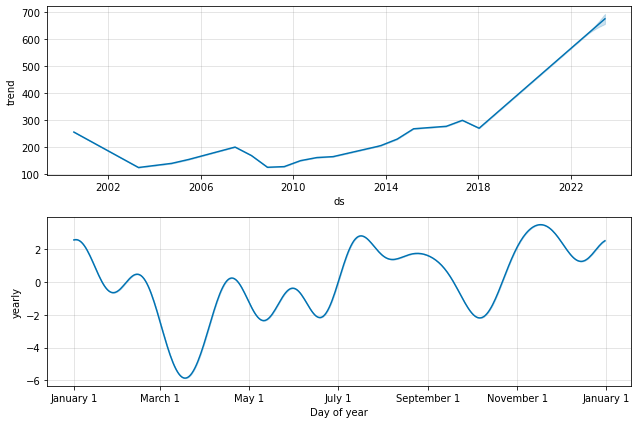

In [14]:
fig2 = m.plot_components(forecast)

An interactive figure of the forecast and components can be created with plotly. You will need to install plotly 4.0 or above separately, as it will not by default be installed with prophet. You will also need to install the notebook and ipywidgets packages.

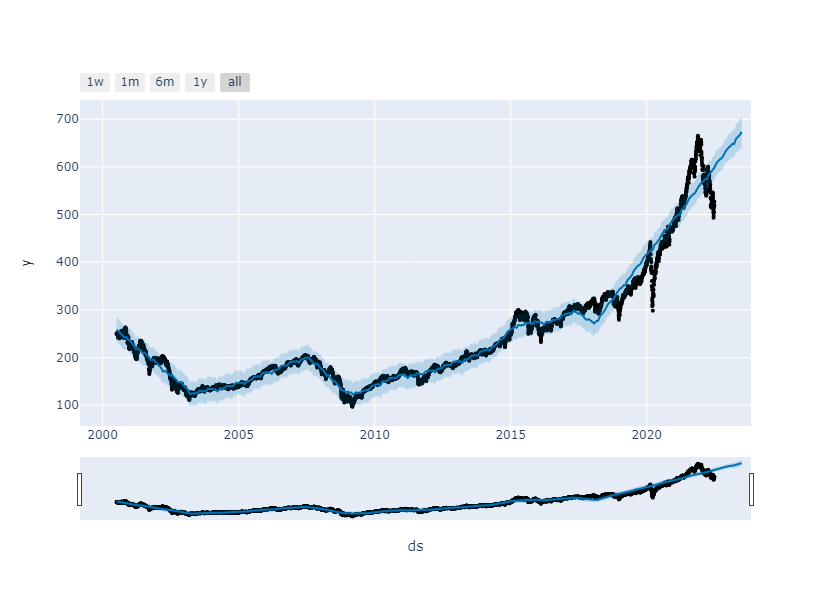

In [15]:
from prophet.plot import plot_plotly, plot_components_plotly

plot_plotly(m, forecast)

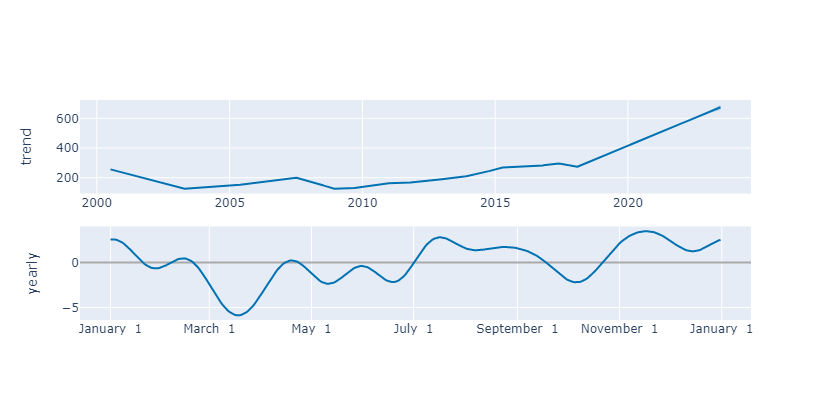

In [16]:
plot_components_plotly(m, forecast)

## Parallelized Cross validation

In [17]:
df_cv = cross_validation(m, horizon='30 days', parallel="dask")

INFO:prophet:Making 509 forecasts with cutoffs between 2001-07-18 00:00:00 and 2022-05-29 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:64429' processes=4 threads=8, memory=15.39 GiB>


In [22]:
df_cv.tail()

ds        yhat  yhat_lower  yhat_upper       y     cutoff
10542 2022-06-22  604.078307  578.862913  629.955413  504.83 2022-05-29
10543 2022-06-23  604.194995  579.467018  630.366669  514.48 2022-05-29
10544 2022-06-24  604.324246  580.059250  629.087451  527.69 2022-05-29
10545 2022-06-27  604.804276  581.814344  630.301571  526.49 2022-05-29
10546 2022-06-28  604.998541  579.128204  628.338175  519.14 2022-05-29

In [19]:
df_p = performance_metrics(df_cv)
df_p.head()

horizon         mse       rmse        mae      mape     mdape     smape  \
0  3 days  631.031185  25.120334  15.435248  0.060555  0.040140  0.062001   
1  4 days  653.978140  25.572996  15.829783  0.061855  0.040163  0.063294   
2  5 days  644.880589  25.394499  15.876096  0.062692  0.040618  0.064084   
3  6 days  648.480868  25.465288  15.993393  0.063626  0.041152  0.065050   
4  7 days  647.593434  25.447857  15.982017  0.063581  0.041945  0.065007   

   coverage  
0  0.507067  
1  0.503795  
2  0.506163  
3  0.504765  
4  0.494789

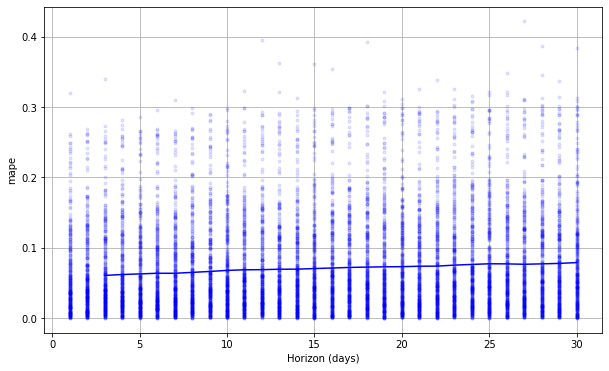

In [20]:
from prophet.plot import plot_cross_validation_metric
fig = plot_cross_validation_metric(df_cv, metric='mape')

### Next:

1) Can more hyperparameter tuning can be done to significantly improve accuracy?
2) Check if Prophet's output has been suppressed 
3) If necessary, re-order the analysis in the notebook and automate the analysis wherever possible
4) Remove any unnecessary or low value steps from the analysis 
5) Document the notebook 
6) Create a .py script of the notebook 
7) Publish the project publicly on Github

## Calculate the analysis' and forecast's timing

In [21]:
# Calculate and print the time elapsed to run ETL process and the date and time of the latest run
time_elapsed = timeit.default_timer() - start_time

time_elapsed_minutes = int((time_elapsed % 3600) // 60)

time_elapsed_seconds = int(time_elapsed % 60)

now = dt.datetime.now()

print("\n Success! Your GSEF forecast using Prophet has been updated in {} minutes and {} seconds on {}".format(time_elapsed_minutes, time_elapsed_seconds, now.strftime("%Y-%m-%d %H:%M:%S")))


 Success! Your GSEF forecast using Prophet has been updated in 1 minutes and 38 seconds on 2022-06-30 11:29:04
